### Imports

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm import trange
from pathlib import Path

import torch
import pickle
import string
import itertools

import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from cdt.metrics import SHD

from simulation.simulation_tools import get_optimal_sim_XY, get_optimal_sim_XY_dual
from utils import custom_binary_metrics, _from_full_to_cp, _from_cp_to_full, regular_order_pd

from simulation.simulation_configs import cd_config as CD_CONFIGS
from simulation.simulation_configs import pred_config as PRED_CONFIGS
from simulation.simulation_configs import noise_config as NOISE_CONFIGS

rng = np.random.default_rng()

COL_NAMES = list(string.ascii_uppercase) + ["".join(a) for a in list(itertools.permutations(list(string.ascii_uppercase), r=2))]

Detecting 1 CUDA device(s).


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


### Experiment 
Observe the behavior of TCS when given the ground truth graph (oracle) as the 1st phase's output.

In [ ]:
# data_path
ie_custom_path = list(Path(".").resolve().parents)[1] / "data" / "cp_style" / "increasing_edges_cp_1"


# configs & oracle
CONFIGS = [
    {
        "cd": cd_method, 
        "fc": fc_method,
        "z": z_approximation,
        "o": z_approximation
    } for cd_method in list(CD_CONFIGS.values()) 
    for fc_method in list(PRED_CONFIGS.values())
    for z_approximation in list(NOISE_CONFIGS.values())
]


# placeholders
errors = []
scm_list = {}
shd_list = {}
scores_list = {}
det_auc_list = {}
struct_auc_list = {}

errors_w = []
scm_list_w = {}
shd_list_w = {}
scores_list_w = {}
det_auc_list_w = {}
struct_auc_list_w = {}



# run loop
for fn in os.listdir(ie_custom_path / "data"):
        print(f"\n\n------------------------------------- {fn} -------------------------------------")

        # read the time-series
        X_data = pd.read_csv(ie_custom_path / "data" / fn)
        X_data.rename(columns=dict(zip(X_data.columns, COL_NAMES[:X_data.shape[1]])), inplace=True)

        # read the ground truth
        gn = fn.split("_ts")[0] + "_struct.pt"
        Y_data = torch.load(ie_custom_path / "structure" / gn)
        Y_data[Y_data > 0] = 1      # carefull here
        Y_data_pd = _from_cp_to_full(Y_data)
        Y_data_pd = Y_data_pd.loc[regular_order_pd(Y_data_pd), regular_order_pd(Y_data_pd)]
        # print(f"- edges : {Y_data.sum().int()}")

        CD_CONFIGS['ORACLE_1'] = {
                "cd_method": "ORACLE",
                "cd_kwargs": {
                        "oracle": Y_data_pd.copy()
                }
        }

        # optimal simulation
        res, res_s = get_optimal_sim_XY_dual(
                true_data = X_data, 
                CONFIGS = None, 
                done_eval = False,
                optimal_det_config = None,
                optimal_det_func = None, 
                sparsity_penalty=True,
                verbose = False
        )

        # compare
        if isinstance(res["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res["optimal_scm"])
        else:
                pred_cp = res["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list[fn] =  pred_cp
        scores_list[fn] =  res["scores"]
        det_auc_list[fn] =  res["auc"]
        struct_auc_list[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list[fn] = shd_d

        # ___________________________________________________________________________________________


        # compare
        if isinstance(res_s["optimal_scm"], pd.DataFrame):
                pred_cp = _from_full_to_cp(res_s["optimal_scm"])
        else:
                pred_cp = res_s["optimal_scm"].causal_structure.causal_structure_cp
        true_cp = Y_data
        if  true_cp.shape[2]>pred_cp.shape[2]:
                pred_cp = torch.nn.functional.pad(input=pred_cp, pad=(0, true_cp.shape[2] - pred_cp.shape[2], 0, 0, 0, 0), value=0)
        if  pred_cp.shape[2]>true_cp.shape[2]:
                true_cp = torch.nn.functional.pad(input=true_cp, pad=(0, pred_cp.shape[2] - true_cp.shape[2], 0, 0, 0, 0), value=0)
        tpr, fpr, tnr, fnr, auc = custom_binary_metrics(binary=pred_cp, A=true_cp, verbose=True)
        shd_d = SHD(target=true_cp.numpy(), pred=pred_cp.numpy(), double_for_anticausal=True)

        # store
        scm_list_w[fn] =  pred_cp
        scores_list_w[fn] =  res_s["scores"]
        det_auc_list_w[fn] =  res_s["auc"]
        struct_auc_list_w[fn] =  {"tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr, "auc": auc, "shd": shd_d,
                                "pred#": pred_cp.sum().numpy(), "true#": true_cp.sum().numpy()}
        shd_list_w[fn] = shd_d

        # ___________________________________________________________________________________________



------------------------------------- (000)_cp_v10_l1_p95_ts.csv -------------------------------------
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1223.59it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 141.37it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5314900153609831 (auc) || configs: 12 || elapsed_time: 4.69 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5125704929961796 (auc) || configs: 8 || elapsed_time: 8.93 (s)
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 975.84it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:06<00:00, 149.37it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5374005984095745 (auc) || configs: 12 || elapsed_time: 4.72 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5449278846153847 (auc) || configs: 8 || elapsed_time: 8.09 (s)
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1183.38it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


 54%|█████▍    | 555/1020 [00:03<00:03, 151.70it/s]


LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1271.84it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 1020/1020 [00:07<00:00, 130.65it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


  0%|          | 0/12 [00:00<?, ?it/s]

### Store Results

In [ ]:
# merge
res_both = {
    "res" : struct_auc_list,
    "res_w" : struct_auc_list_w, 
}

# # store results
# pickle.dump(res_both, open("data" / "results" / "oracle_graph" / "res_cp_ora_1.p", "wb"))

### Plot

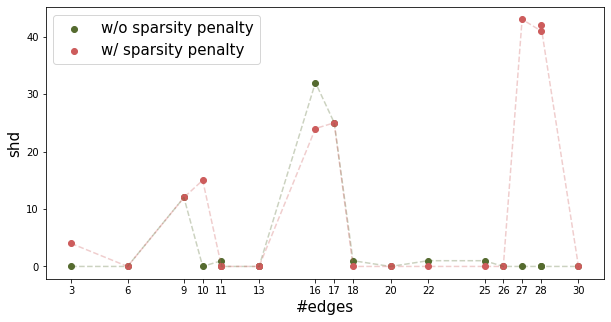

In [3]:
# load data
res_both = pickle.load(open(list(Path(".").resolve().parents)[1] / "data" / "results" / "oracle_graph" / "res_cp_ora_1.p", "rb"))

# sort results according to ground truth edge density
sorted_true, sorted_shd = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res'].values())], 
    [v["shd"] for v in list(res_both['res'].values())])), key=lambda x: x[0])[:])) 

sorted_true_w, sorted_shd_w = list(zip(*sorted(list(zip(
    [v["true#"] for v in list(res_both['res_w'].values())], 
    [v["shd"] for v in list(res_both['res_w'].values())])), key=lambda x: x[0])[:])) 

# plot
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x=sorted_true, y=sorted_shd, label="w/o sparsity penalty", color="darkolivegreen")
ax.plot(sorted_true, sorted_shd, "--", color="darkolivegreen", alpha=0.3)
ax.scatter(x=sorted_true_w, y=sorted_shd_w, label="w/ sparsity penalty", color='indianred')
ax.plot(sorted_true_w, sorted_shd_w, "--", color='indianred', alpha=0.3)
ax.set_xticks(list(set([int(x) for x in sorted_true])))
ax.set_xticklabels(list(set([int(x) for x in sorted_true])))
ax.set_xlabel("#edges", fontdict={"size": 15})
ax.set_ylabel("shd", fontdict={"size": 15})
# ax.set_title("SHD on synthetic data w/ increasing # of edges.")
ax.legend(fontsize=15)
plt.show()